In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cuda


In [2]:
!wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav

--2024-09-19 22:20:09--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.108.153, 185.199.110.153, 185.199.109.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: ‘gt_bach.wav.4’

gt_bach.wav.4       100%[===================>]   1.17M  --.-KB/s    in 0.08s   

2024-09-19 22:20:10 (14.6 MB/s) - ‘gt_bach.wav.4’ saved [1232886/1232886]



In [3]:
from IPython.display import Audio
Audio('gt_bach.wav')

In [4]:
import torchaudio
audio, sr = torchaudio.load('./gt_bach.wav')
print(sr)
print(audio.shape)
audio = audio[0]

44100
torch.Size([1, 308207])


In [5]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 6.988820861678004 seconds


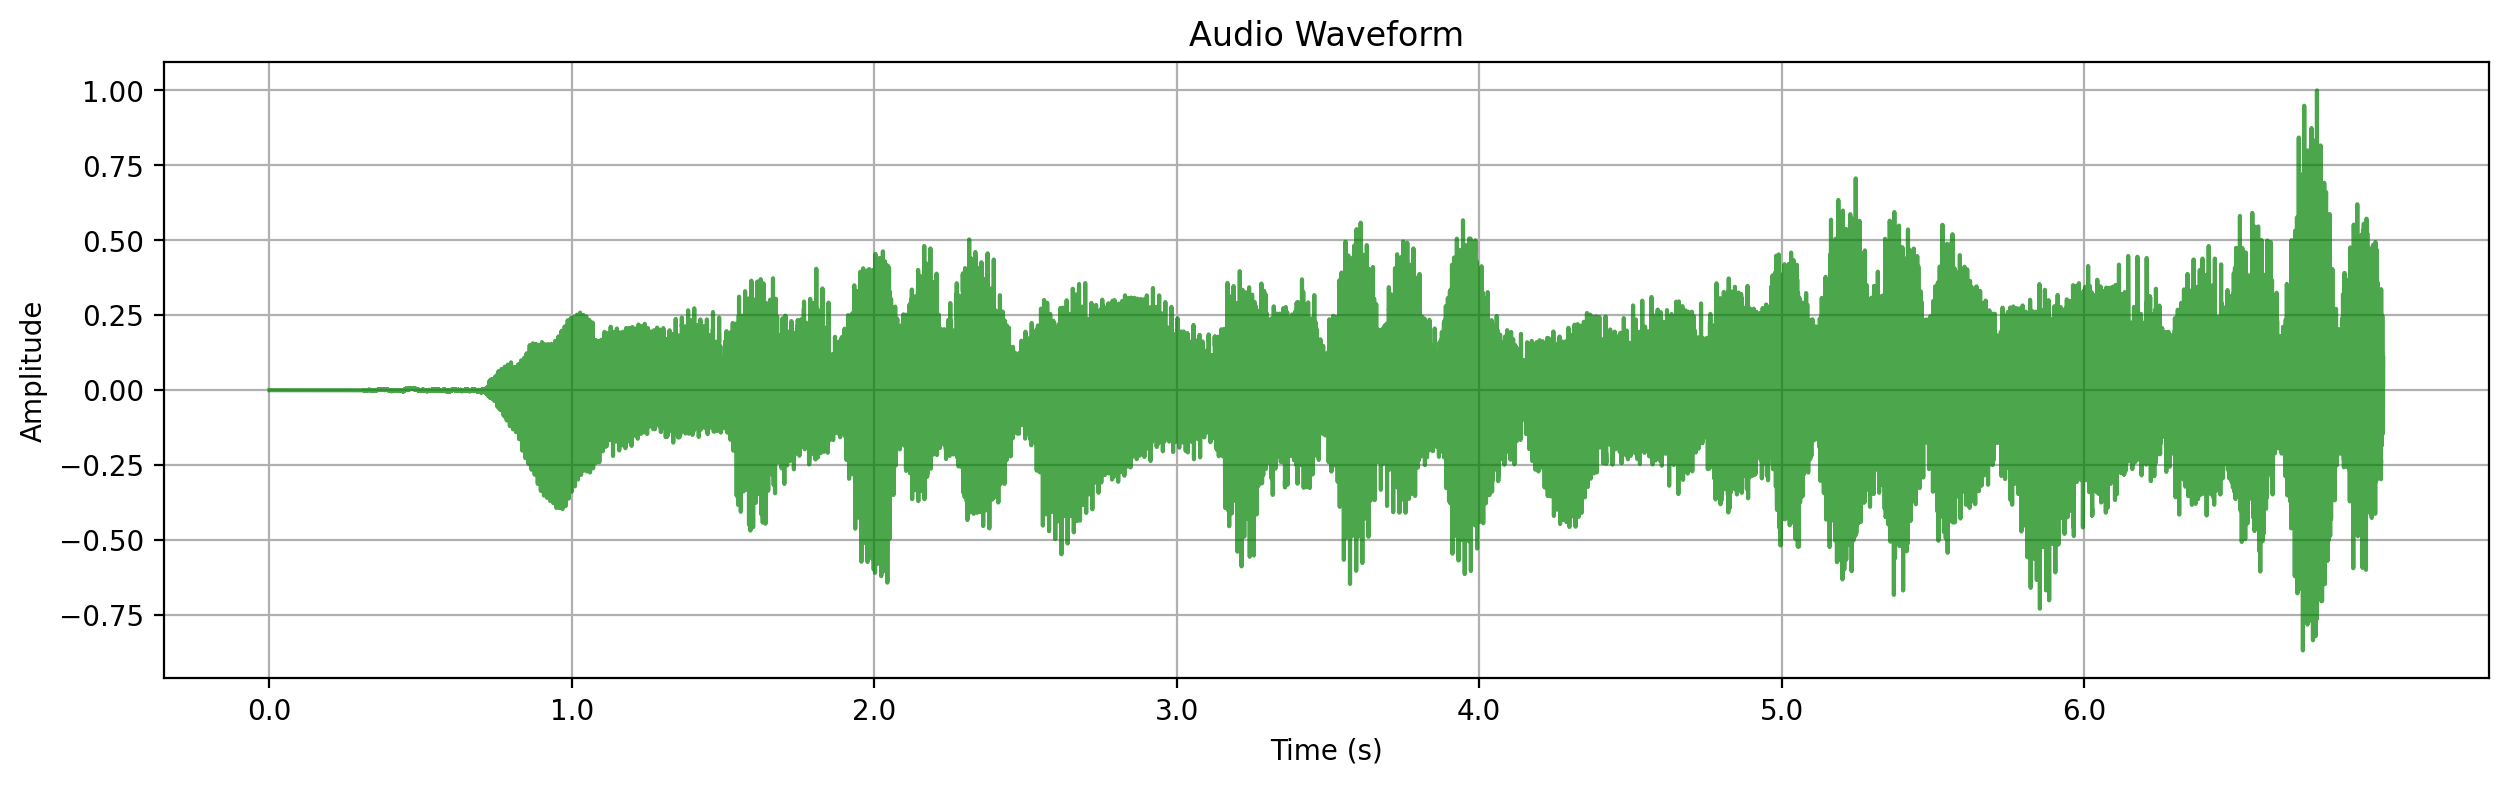

In [6]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [7]:
audio = audio[-5 * sr:]
print(audio.shape)
print(audio)

torch.Size([220500])
tensor([-0.4993, -0.4846, -0.4692,  ...,  0.0473,  0.0297,  0.0168])


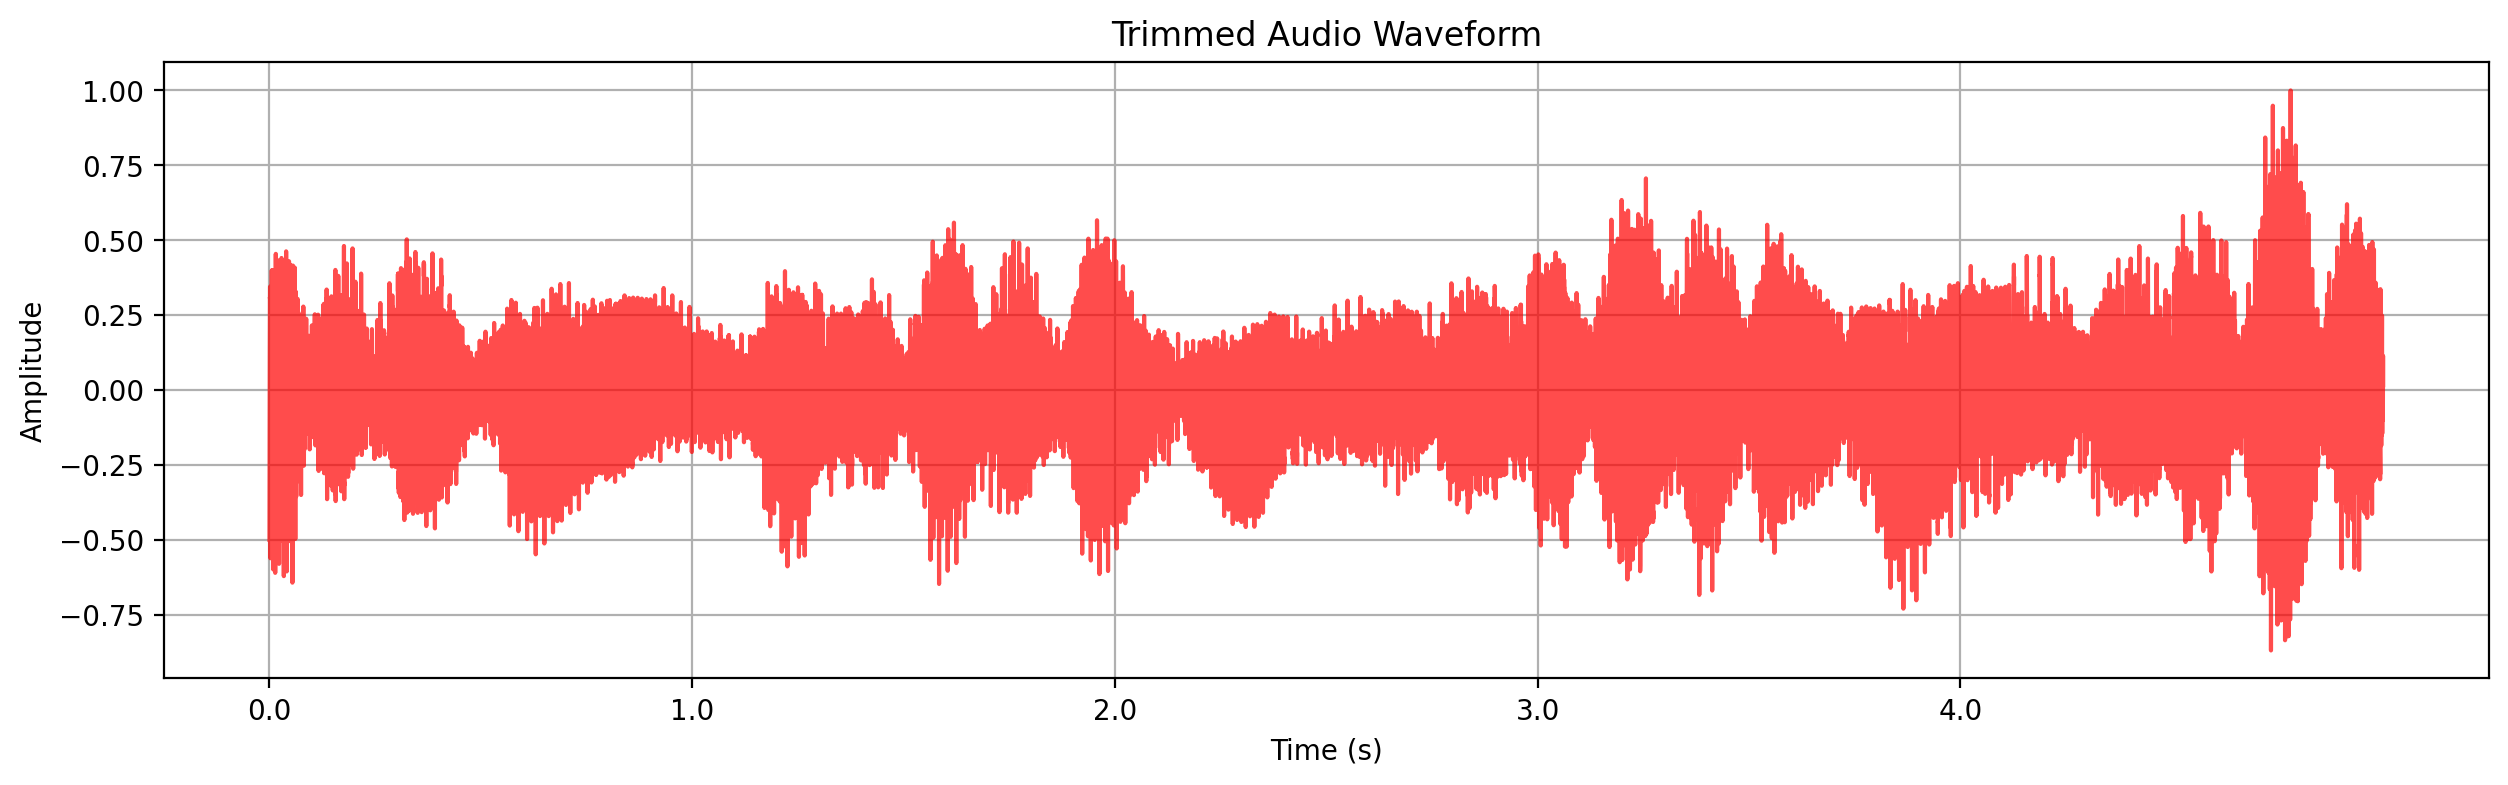

In [8]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

In [9]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [10]:
Audio(audio, rate = sr)

In [11]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [12]:
num_features = 2500
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 2500])
tensor([[ 0.0279,  0.0177, -0.0281,  ..., -0.0199,  0.0264, -0.0244],
        [ 0.0282,  0.0158, -0.0281,  ..., -0.0178,  0.0246, -0.0263],
        [ 0.0283,  0.0137, -0.0281,  ..., -0.0155,  0.0223, -0.0276],
        ...,
        [-0.0275, -0.0010, -0.0269,  ..., -0.0176, -0.0156, -0.0276],
        [-0.0279, -0.0035, -0.0268,  ..., -0.0153, -0.0189, -0.0282],
        [-0.0282, -0.0058, -0.0268,  ..., -0.0128, -0.0217, -0.0282]])


In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [14]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [15]:
print(pred_audio)
print(audio)

[-0.06645305 -0.06626387 -0.06601365 ...  0.01189678  0.01225524
  0.01197212]
tensor([-0.4993, -0.4846, -0.4692,  ...,  0.0473,  0.0297,  0.0168])


In [16]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(74.56602, 27210.385)

In [17]:
Audio(pred_audio, rate = sr)

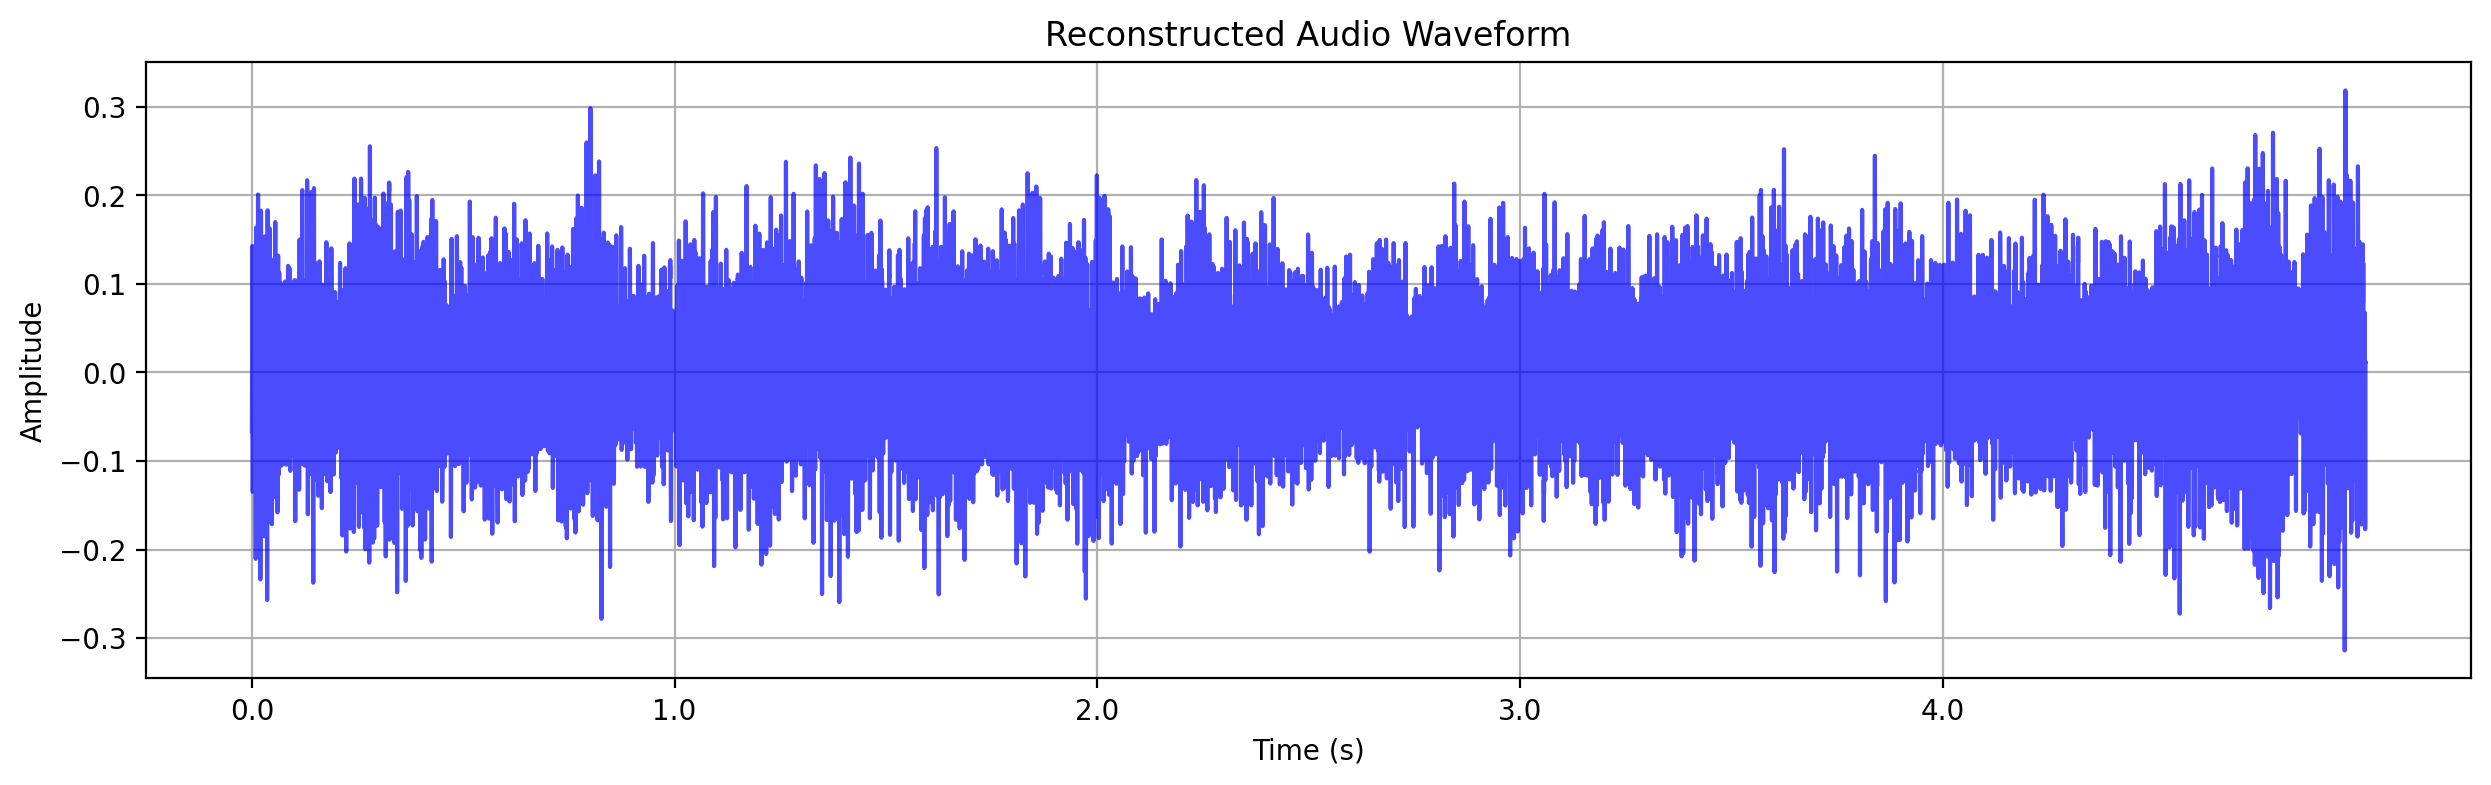

In [18]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

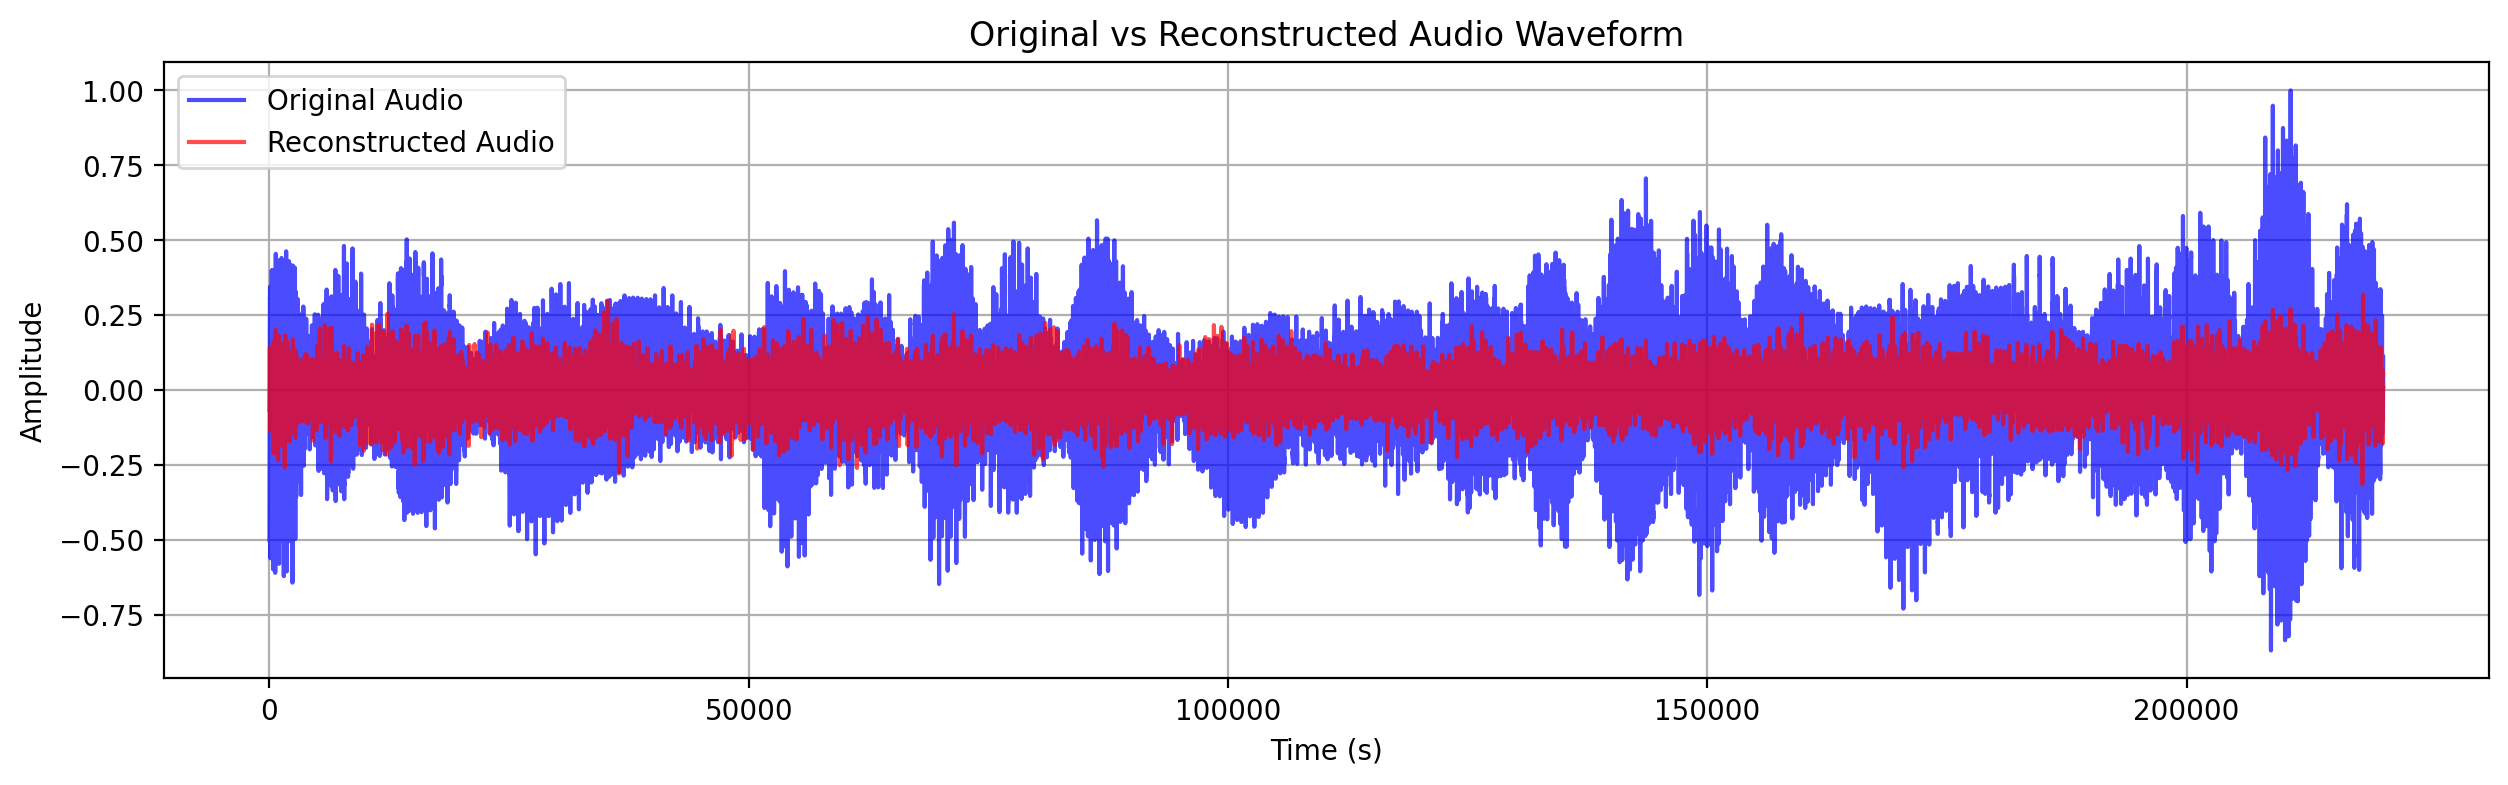

In [19]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [21]:

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

def snr(y_true, y_pred):
    signal = torch.sum(y_true**2)
    noise = torch.sum((y_true - y_pred)**2)
    return 10 * torch.log10(signal / noise)

print(f"RMSE: {rmse(audio, torch.tensor(pred_audio)).item()}")
print(f"SNR: {snr(audio, torch.tensor(pred_audio)).item()}")


RMSE: 0.15879492461681366
SNR: 0.8502215147018433
